# InsCure Capstone Project

This is our notebook for Inscure, Chat-Based Skin Disease Analysis Using Image Detection model development.


### Import the Library


In [ ]:
# Import Library
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import sklearn
import shutil
import random
import string
import cv2
import tempfile
from tensorflow import keras
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, load_img
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, Conv2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

### Load dataset from Google Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Split Data into Training Set and Validation Set

In [ ]:
# Defining the directory
dataset_directory = '/content/drive/MyDrive/Capstone_Project/Capstone_Dataset/'

# Setting parameters
batch_size = 32
img_height = 224
img_width = 224
validation_split = 0.2
image_shape = (img_height, img_width, 3)

# Creating the training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_directory,
    validation_split=validation_split,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    labels='inferred'
)

# Creating the validation dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_directory,
    validation_split=validation_split,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    labels='inferred'
)

# Printing class names
class_names = train_dataset.class_names
print("Class names:", class_names)

Found 1099 files belonging to 11 classes.
Using 880 files for training.
Found 1099 files belonging to 11 classes.
Using 219 files for validation.
Class names: ['Athlete Foot', 'BCC', 'Cellulitis', 'Chickenpox', 'Impetigo', 'Keratosis', 'Melanoma', 'NV', 'Nail Fungus', 'Ringworm', 'Shingles']


### Sample Visualization


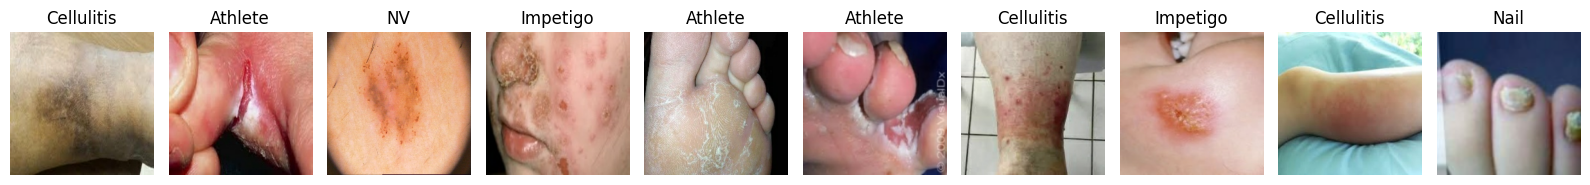

In [ ]:
# Plotting a sample of 10 images from the training set
def plot_categories(train_dataset, class_names):
  fig, axes = plt.subplots(1, 10, figsize=(16, 15))
  axes = axes.flatten()
  letters = list(string.ascii_lowercase)

  for images, labels in train_dataset.take(1):
    for k in range(10):
      img = images[k].numpy()
      img = array_to_img(img)
      ax = axes[k]
      label = class_names[int(labels[k])]
      simplified_label = label.split()[0]
      ax.imshow(img, cmap="Greys_r")
      ax.set_title(simplified_label)
      ax.set_axis_off()

  plt.tight_layout()
  plt.show()

plot_categories(train_dataset, class_names)

### Making the Generator for CNN and Data Augmentation

In [ ]:
train_dataset_dir ='/content/drive/MyDrive/Capstone_Project/train_dir/'
validation_dataset_dir ='/content/drive/MyDrive/Capstone_Project/validation_dir/'

In [ ]:
# Augmentation configuration for the training dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=validation_split
)

# Only rescaling for the validation dataset
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=validation_split)

# Creating the training dataset
train_generator = train_datagen.flow_from_directory(
    directory = train_dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='training'
)

# Creating the validation dataset
validation_generator = validation_datagen.flow_from_directory(
    directory = validation_dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation'
)

# Printing class names
class_names = list(train_generator.class_indices.keys())
print(f"Class: {class_names}")

Found 710 images belonging to 11 classes.
Found 40 images belonging to 11 classes.
Class: ['Athlete Foot', 'BCC', 'Cellulitis', 'Chickenpox', 'Impetigo', 'Keratosis', 'Melanoma', 'NV', 'Nail Fungus', 'Ringworm', 'Shingles']


### Checking the Distribution for Training Set and Validation Set

Distribusi kelas di set pelatihan: Counter({7: 84, 1: 84, 10: 83, 2: 82, 8: 81, 5: 81, 6: 80, 0: 79, 3: 79, 9: 79, 4: 68})


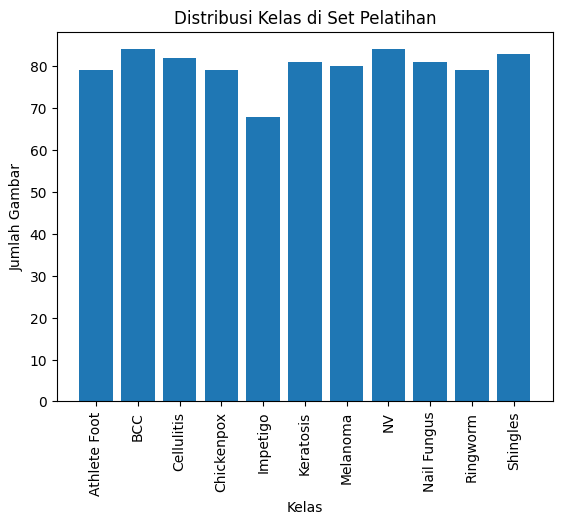

In [ ]:
import collections

# Class distribution in training dataset
class_count = collections.Counter()
for images, labels in train_dataset:
    class_count.update(labels.numpy())

print("Distribusi kelas di set pelatihan:", class_count)

# Visualization
plt.bar(class_count.keys(), class_count.values())
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=90)
plt.title('Distribusi Kelas di Set Pelatihan')
plt.show()

Distribusi kelas di set validasi: Counter({4: 32, 9: 21, 0: 21, 3: 21, 6: 20, 5: 19, 8: 19, 10: 17, 2: 17, 1: 16, 7: 16})


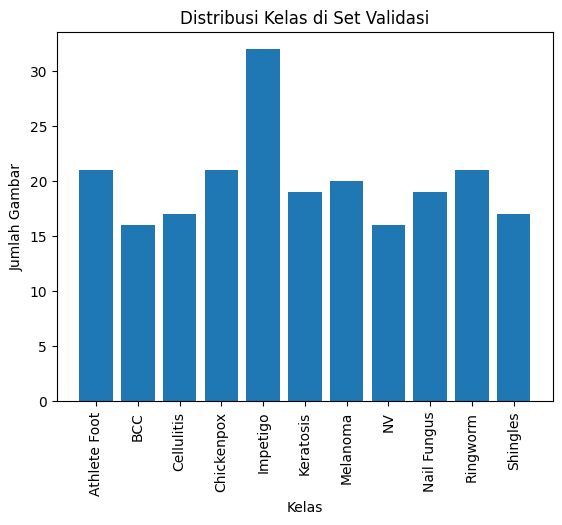

In [ ]:
# Class distribution in validation dataset
class_count = collections.Counter()
for images, labels in validation_dataset:
    class_count.update(labels.numpy())

print("Distribusi kelas di set validasi:", class_count)

# Visualization
plt.bar(class_count.keys(), class_count.values())
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=90)
plt.title('Distribusi Kelas di Set Validasi')
plt.show()

### Model Development Utilizing Pre-Trained Model MobileNetV2


In [ ]:
# Define the base model
base_model = MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
base_model.trainable = False

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(11, activation='softmax')
])


optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define custom callback
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > 0.92 and logs.get('val_accuracy') > 0.92:
            print(f"\nReached 92% accuracy and validation accuracy. Stopping training.")
            self.model.stop_training = True

# Instantiate the custom callback
callback = MyCallback()


# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    callbacks=callback
)

# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/100
23/23 [==============================] - 325s 14s/step - loss: 2.0021 - accuracy: 0.3268 - val_loss: 0.9947 - val_accuracy: 0.7500
Epoch 2/100
23/23 [==============================] - 11s 470ms/step - loss: 1.2623 - accuracy: 0.5577 - val_loss: 0.7522 - val_accuracy: 0.8250
Epoch 3/100
23/23 [==============================] - 12s 493ms/step - loss: 0.9161 - accuracy: 0.6662 - val_loss: 0.5686 - val_accuracy: 0.8500
Epoch 4/100
23/23 [==============================] - 12s 526ms/step - loss: 0.7880 - accuracy: 0.7324 - val_loss: 0.5645 - val_accuracy: 0.8750
Epoch 5/100
23/23 [==============================] - 12s 530ms/step - loss: 0.6940 - accuracy: 0.7606 - val_loss: 0.5442 - val_accuracy: 0.7750
Epoch 6/100
23/23 [==============================] - 12s 531ms/step - loss: 0.6782 - accuracy: 0.7718 - val_loss: 0.5060 - val_accuracy: 0.8250
Epoch 7/100
23/23 [==============================] - 11s 503ms/step - loss

### Visualization for Loss and Accuracy


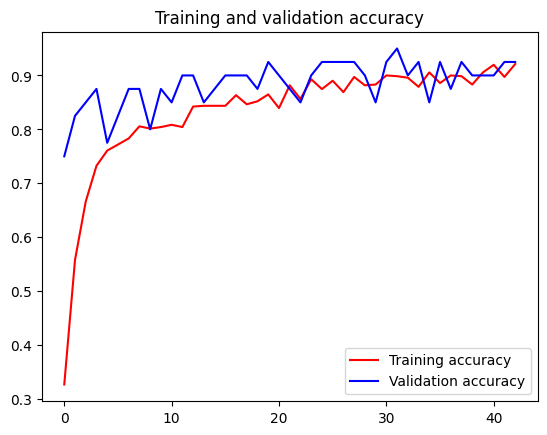

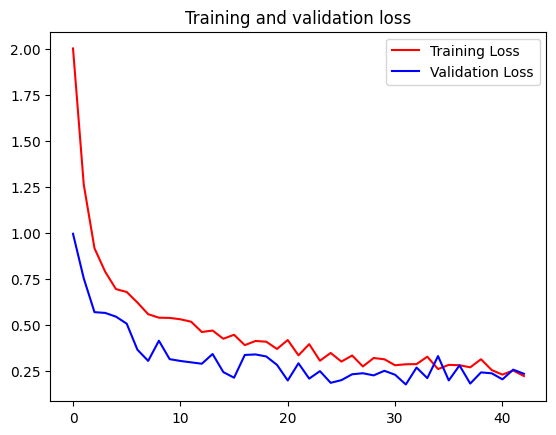

In [ ]:
# Plotting the chart for accuracy and loss on both training and validation for analysis process
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 11)                2827      
                                                                 
Total params: 2588747 (9.88 MB)
Trainable params: 330763

In [ ]:
# Save the model to HDF5 format
model.save('/content/drive/MyDrive/Capstone_Model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from google.colab import files

# Download the model
files.download('/content/drive/MyDrive/Capstone_Model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>